### Changes

#### Get Paper Counts Up to Year Published
- get the paper and citation counts up until year that they published in journal
- all unique authors and editors
- for each contributor, get all their papers1
- get number of papers1 published per year/end of bin?
- line with confidence interval (look into seaborn)

#### Stick to Random Duplicates

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
"""
paperyear is year they published in given journal
year is year other non-journal paper was published
"""
def paper_count_plot_year(journal, author_data, author_all_papers, editor_data,  editor_all_papers, tenures):
    authors = pd.read_csv(author_data, usecols=['Year', 'AuthorId']).dropna(subset=['AuthorId'])
    authors = authors.astype({'AuthorId': int})
    authors = authors.rename(columns={'Year': 'PaperYear'})
    authors = authors.sort_values(by=['PaperYear'])
    authors = authors.drop_duplicates(subset=['AuthorId'], keep='last')
    
    editors = pd.read_csv(editor_data, usecols=['Name', 'AuthorId']).dropna(subset=['AuthorId'])
    editors = editors.astype({'AuthorId': int})
    tenures = pd.read_csv(tenures, usecols=['Name', 'End'], names=['Name', 'Role', 'Start', 'End', 'Aff'])
    editors = editors.merge(tenures, on=['Name'], how='inner')
    editors = editors.rename(columns={'End': 'PaperYear'})
    editors = editors.sort_values(by=['PaperYear'])
    editors = editors.drop_duplicates(subset=['AuthorId'], keep='last')
    
    author_papers = pd.read_csv(author_all_papers)
    authors = authors.join(author_papers.set_index('AuthorId'), on=['AuthorId'], how='left')
    editor_papers = pd.read_csv(editor_all_papers, usecols=['AuthorId','PaperId','Year','NormalizedName'])
    editors = editors.join(editor_papers.set_index('AuthorId'), on=['AuthorId'], how='left')
    
    authors = authors[authors['PaperYear'] >= authors['Year']]
    authors['PaperCount'] = authors['AuthorId'].groupby(authors.AuthorId).transform('count')
    editors = editors[editors['PaperYear'] >= editors['Year']]
    editors['PaperCount'] = editors['AuthorId'].groupby(editors.AuthorId).transform('count')
    
    return authors, editors

In [12]:
def call_paper_count_plot(journal):
    a, e = paper_count_plot_year(journal,
                                f"../author_data/cleaned/{journal}_authors_cleaned.csv", 
                                f"../author_data/papers/{journal}_author_papers.csv",
                                f"../mag_processed/random_duplicates/{journal}_random_duplicates.csv", 
                                f"../editor_data/papers/{journal}_editor_papers.csv",
                                f"../editor_data/analysis/tenures/{journal}_tenures.csv")
    return a, e

In [6]:
"""
not separated by year because author data is so oddly sparse
"""
# def paper_count_plot_year(author_data, editor_no_dup, editor_rand_dup, journal):
#     authors = pd.read_csv(author_data)
#     authors = authors.dropna(subset=['PaperCount'])
#     editors_no_dup = pd.read_csv(editor_no_dup)
#     editors_rand_dup = pd.read_csv(editor_rand_dup)
    
#     author_papers = authors['PaperCount']
#     editor_papers_no_dup = editors_no_dup['PaperCount']
#     editor_papers_rand_dup = editors_rand_dup['PaperCount']
#     data = [author_papers, editor_papers_no_dup, editor_papers_rand_dup]
    
#     fig = plt.figure(figsize =(6,4))
#     ax = fig.add_axes([0, 0, 1, 1])
#     ax.set_xticklabels(['Authors', 'Editors (No Duplicates)','Editors (Random Duplicates)'])
#     bp = ax.boxplot(data)
#     plt.title(f'Paper Counts of Authors and Editors at {journal.upper()}')
#     plt.show()

'\nnot separated by year because author data is so oddly sparse\n'

In [7]:
# def call_paper_count_plot(journal):
#     paper_count_plot_year(f"../author_data/cleaned/{journal}_authors_cleaned.csv", 
#                           f"../mag_processed/no_duplicates/{journal}_no_duplicates.csv", 
#                           f"../mag_processed/random_duplicates/{journal}_random_duplicates.csv", 
#                           journal)

In [13]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

In [14]:
"""
for authors, count up to year they published in the journal
for editors, count up to end of their tenure
"""
def paper_count_buckets(authors, editors, journal, bins, labels):
    
    authors['Bucket'] = pd.cut(x = authors['PaperYear'], bins = bins, labels = labels, include_lowest = True)
    editors['Bucket'] = pd.cut(x = editors['PaperYear'], bins = bins, labels = labels, include_lowest = True)
    
    authors = authors.drop_duplicates(subset=['AuthorId'], keep='last')
    authors = authors.drop(labels=['AuthorId', 'Unnamed: 0','PaperId','Year','OriginalAuthor_left','NormalizedName','DisplayName'], axis=1)
    authors = authors.dropna(subset=['Bucket'])
    editors = editors.drop_duplicates(subset=['AuthorId'], keep='last')
    editors = editors.drop(labels=['Name','AuthorId','PaperId','Year','NormalizedName'], axis=1)
    editors = editors.dropna(subset=['Bucket'])
    
    return authors, editors
    #drop duplicates on authorid
    #keep paperyear, papercount, bucket, return
#     author_papers = []
#     editor_papers = []
    
#     for label in labels:
#         tmp_authors = authors[authors['Bucket'] == label]['PaperCount']
#         tmp_editors = editors[editors['Bucket'] == label]['PaperCount']
#         author_papers.append(tmp_authors)
#         editor_papers.append(tmp_editors)
    
#     return author_papers, editor_papers

In [15]:
def call_paper_count_buckets(journal):
    author_data = []
    editor_data = f"../mag_processed/random_duplicates/{journal}_random_duplicates.csv"
    tenures = f"../editor_data/analysis/tenures/{journal}_tenures.csv"
    editor_papers = []
    
    std_bins = [1994, 1998, 2003, 2008, 2013, 2018, 2023]
    std_labels = ['1994-1998', '1999-2003', '2004-2008', '2009-2013', '2014-2018', '2018-2023']
    
    eco_bins = [2007, 2011, 2016, 2021, 2023]
    eco_labels = ['2007-2011', '2012-2016', '2017-2021', '2022-2023']

    jpe_bins = [2017, 2021, 2023]
    jpe_labels = ['2017-2021', '2022-2023']
    
    authors, editors = call_paper_count_plot(f"{journal}")
    if journal == "eco":
        a, e = paper_count_buckets(authors, editors, "eco", eco_bins, eco_labels)
        return a, e, eco_labels
    elif journal == "jpe":
        a, e = paper_count_buckets(authors, editors, "jpe", jpe_bins, jpe_labels)
        return a, e, jpe_labels
    else:
        a, e = paper_count_buckets(authors, editors, journal, std_bins, std_labels)
        return a, e, std_labels

In [16]:
def plot(journal, authors, editors, ticks):
    
    sns.lineplot(data=authors, x="PaperYear", y="PaperCount", errorbar=('ci', 95))
    sns.lineplot(data=editors, x="PaperYear", y="PaperCount", errorbar=('ci', 95))

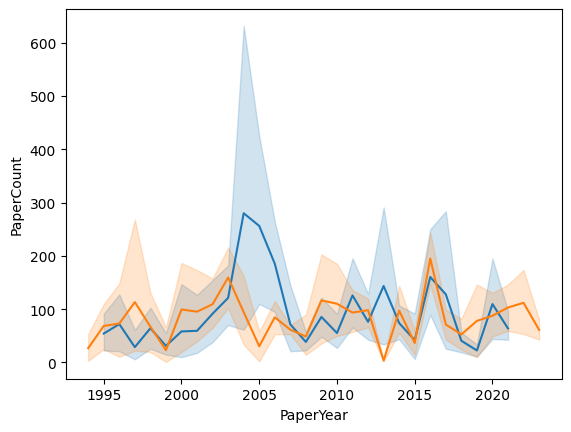

In [17]:
author, editor, labels = call_paper_count_buckets("aer")
plot("aer", author, editor, labels)

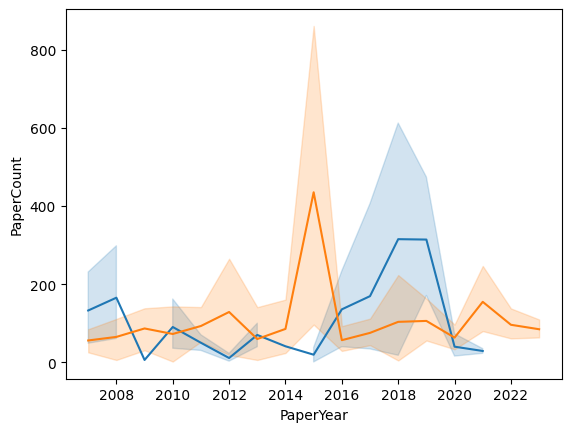

In [18]:
author, editor, labels = call_paper_count_buckets("eco")
plot("eco", author, editor, labels)

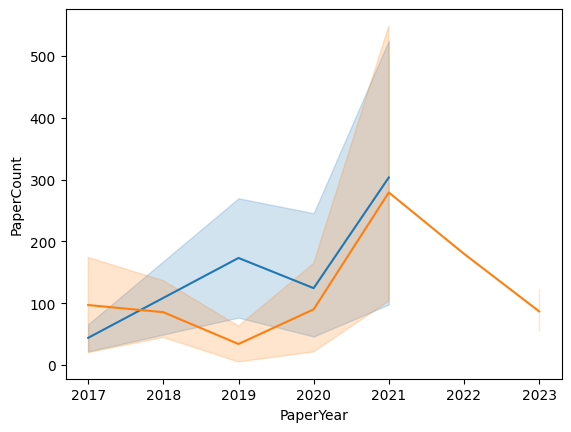

In [19]:
author, editor, labels = call_paper_count_buckets("jpe")
plot("jpe", author, editor, labels)

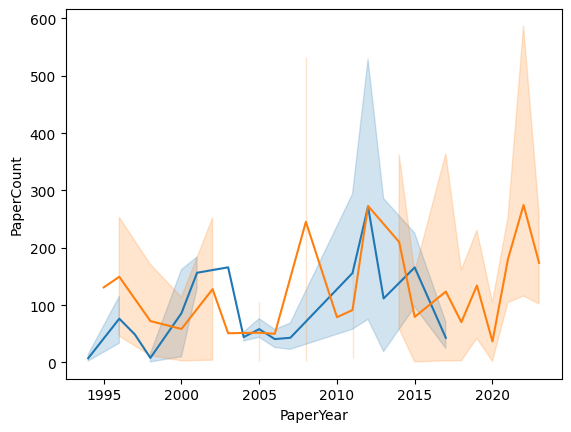

In [20]:
author, editor, labels = call_paper_count_buckets("qje")
plot("qje", author, editor, labels)

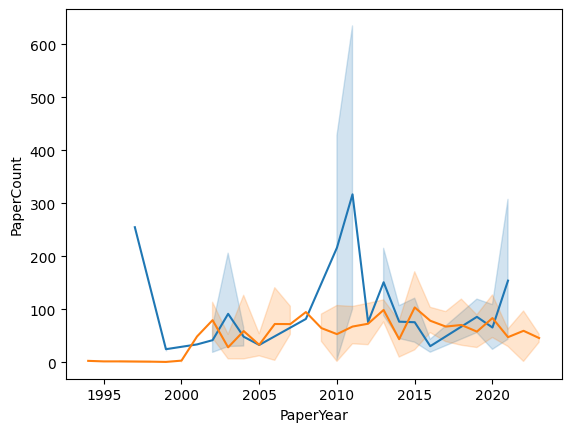

In [21]:
author, editor, labels = call_paper_count_buckets("res")
plot("res", author, editor, labels)